In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
from helper import plot_residuals

sns.set_theme()
mpl.rcParams['figure.figsize'] = (10, 7)
mpl.rcParams["figure.dpi"] = 200

# Introduction to Time-Series Forecasting
## How to solve the market with linear regression?

# What is a linear regression?

## Simple linear regression

We observe the values $(x_1, x_2, x_3, ..., x_n)$ (predictors) and assume the following linear relationship between $X$ and $Y$:
$$ Y = \beta_0 + \beta_1X + \epsilon$$

Where $\epsilon$ is an error term, $\epsilon \sim N(0,1)$

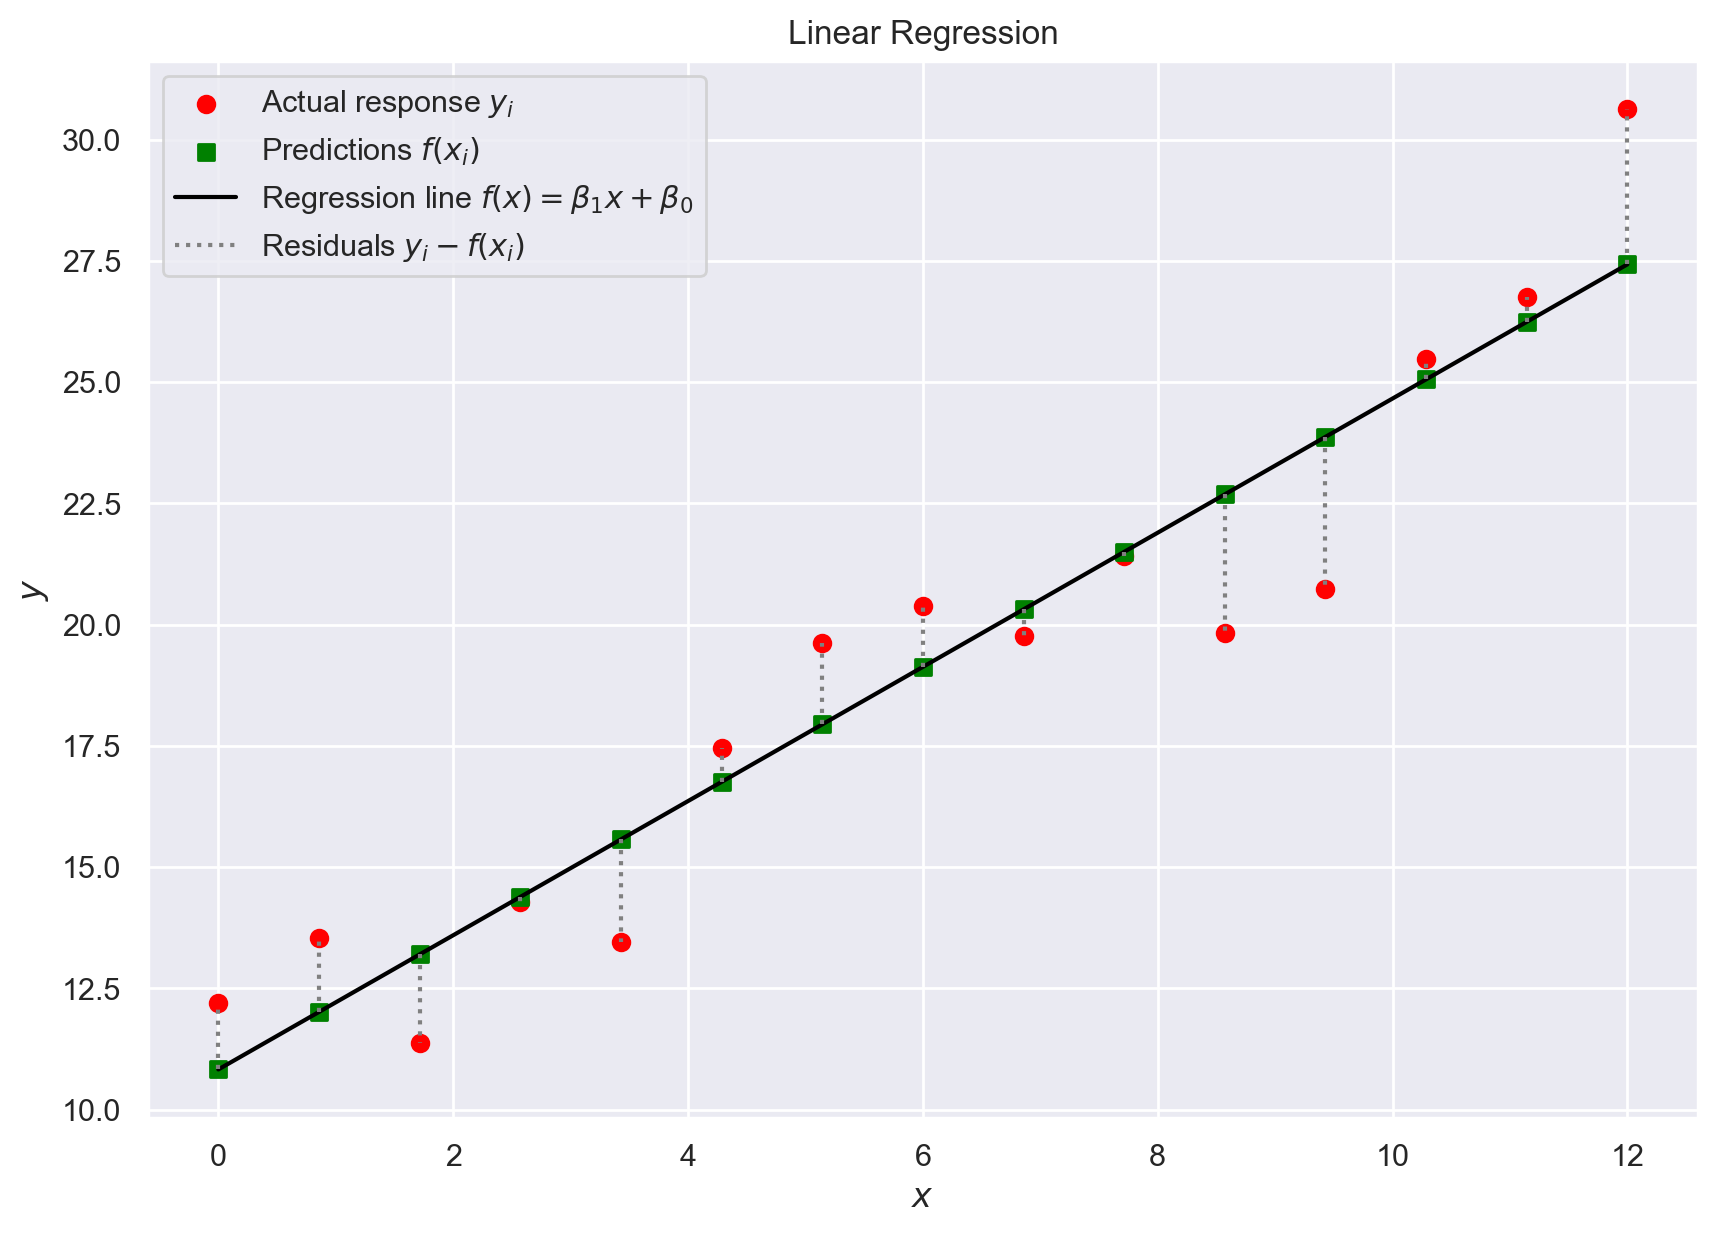

In [133]:
# Simple linear regression
x = np.linspace(0, 12, 15)
error = norm.rvs(size=len(x), scale=2)
y = 10 + 1.5 * x + error

model = sm.OLS(y, sm.add_constant(x))
model_fit = model.fit()

fitted = model_fit.fittedvalues
fig, ax = plt.subplots()
ax.scatter(x, y, label="Actual response $y_i$", color="red")
ax.scatter(x, fitted, label="Predictions $f(x_i)$", marker="s", color="green")
ax.plot(x, fitted, color="black", label="Regression line $f(x) = \\beta_1x + \\beta_0$")
ax.vlines(x, fitted, y, color="grey", linestyle="dotted", 
    label="Residuals $y_i - f(x_i)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Linear Regression")
ax.legend()
plt.show()

The simple linear regression model can be easily extend to a a multiple linear regression model where we have more than one predictor variable.

## Multiple linear regression

There are $p$ predictor variables $X_1, X_2, \ldots, X_p$ and we assume the following model:
$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \ldots + \beta_p X_p + \epsilon$$

Where $\epsilon \sim N(0,1)$. 

## Key assumptions:
- **Linearity**: The relationship between $X$ and $Y$ is linear.
- **Homoscedasticity**: The variance of residual is the same for any value of $X$.
- **Independence**: The residual terms are independent of each other.
- **Normality**: The residuals are normally distributed with mean 0.

# How to asses model fit?

## Diagnostic plots

To check if the model fits well and the assumptions of normality and homoscedasticity hold it is helpful to look at the plot of residuals vs. fitted values. Let's look at the following examples where we assume the simple linear model $Y = \beta_0 + \beta_1X + \epsilon$

1. $Y = 10 + 5X + \epsilon$, good model
2. $Y = 10 + 1.5X + 2X^2 + \epsilon$, bad model, clear relationship
3. $Y = 10 + X + \epsilon \cdot X$, heterosceadastcity

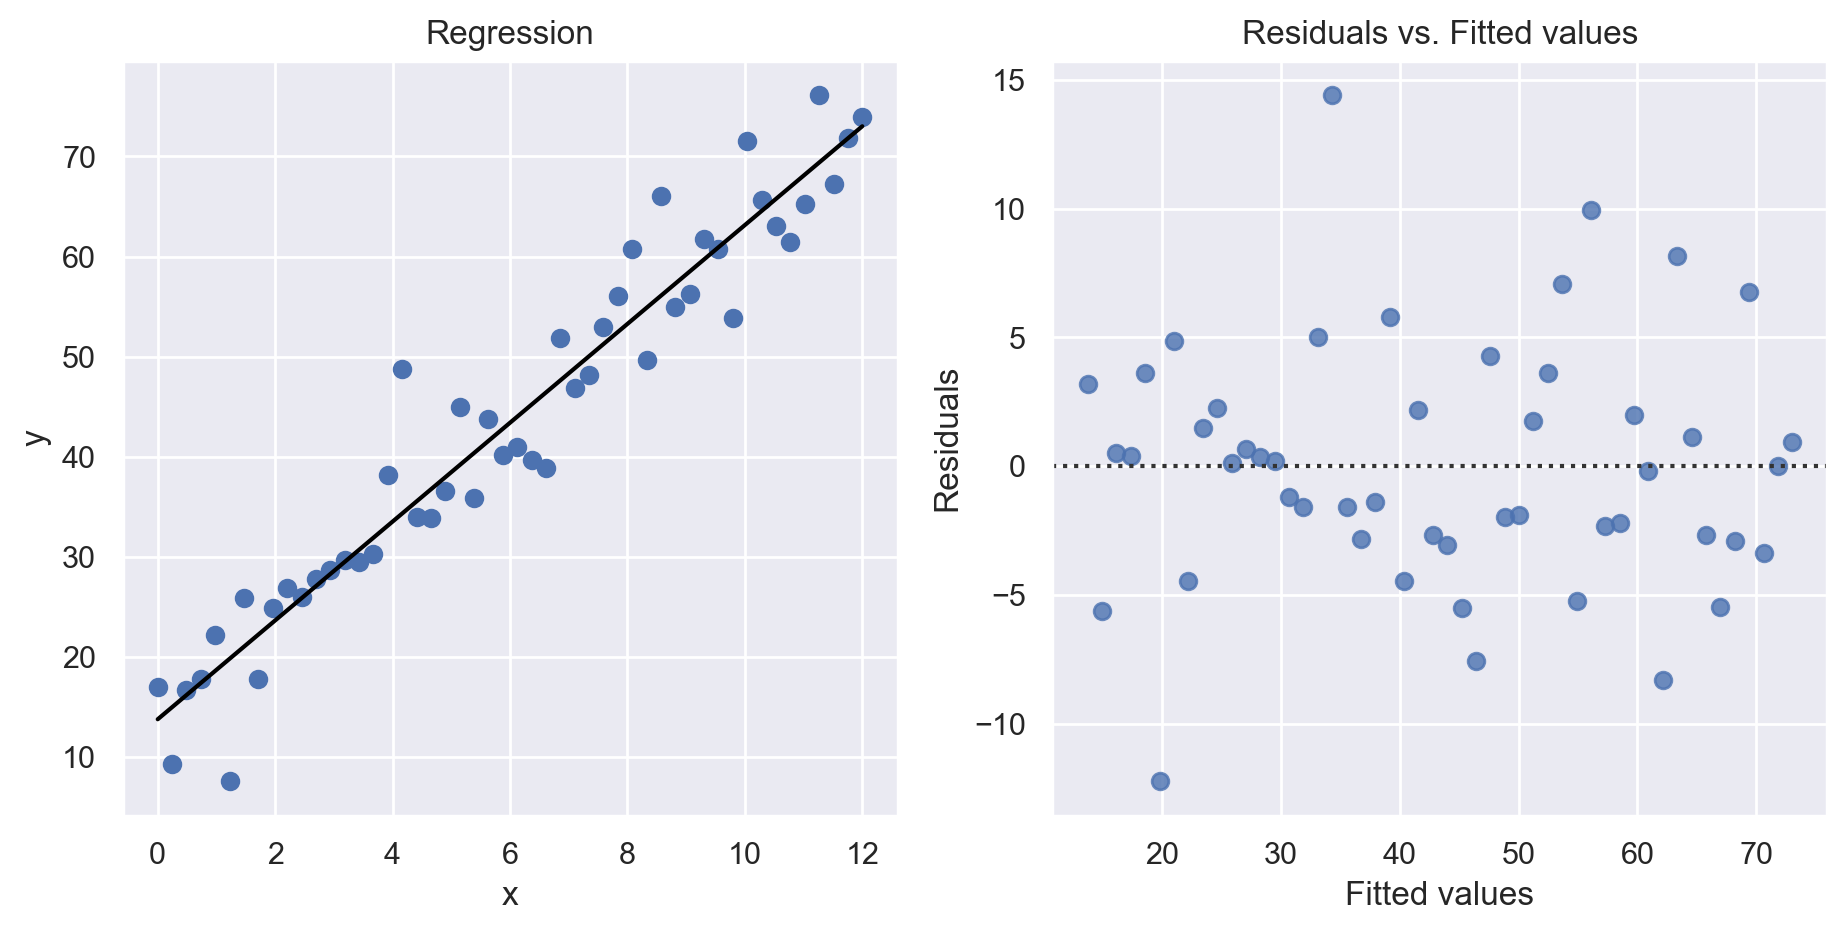

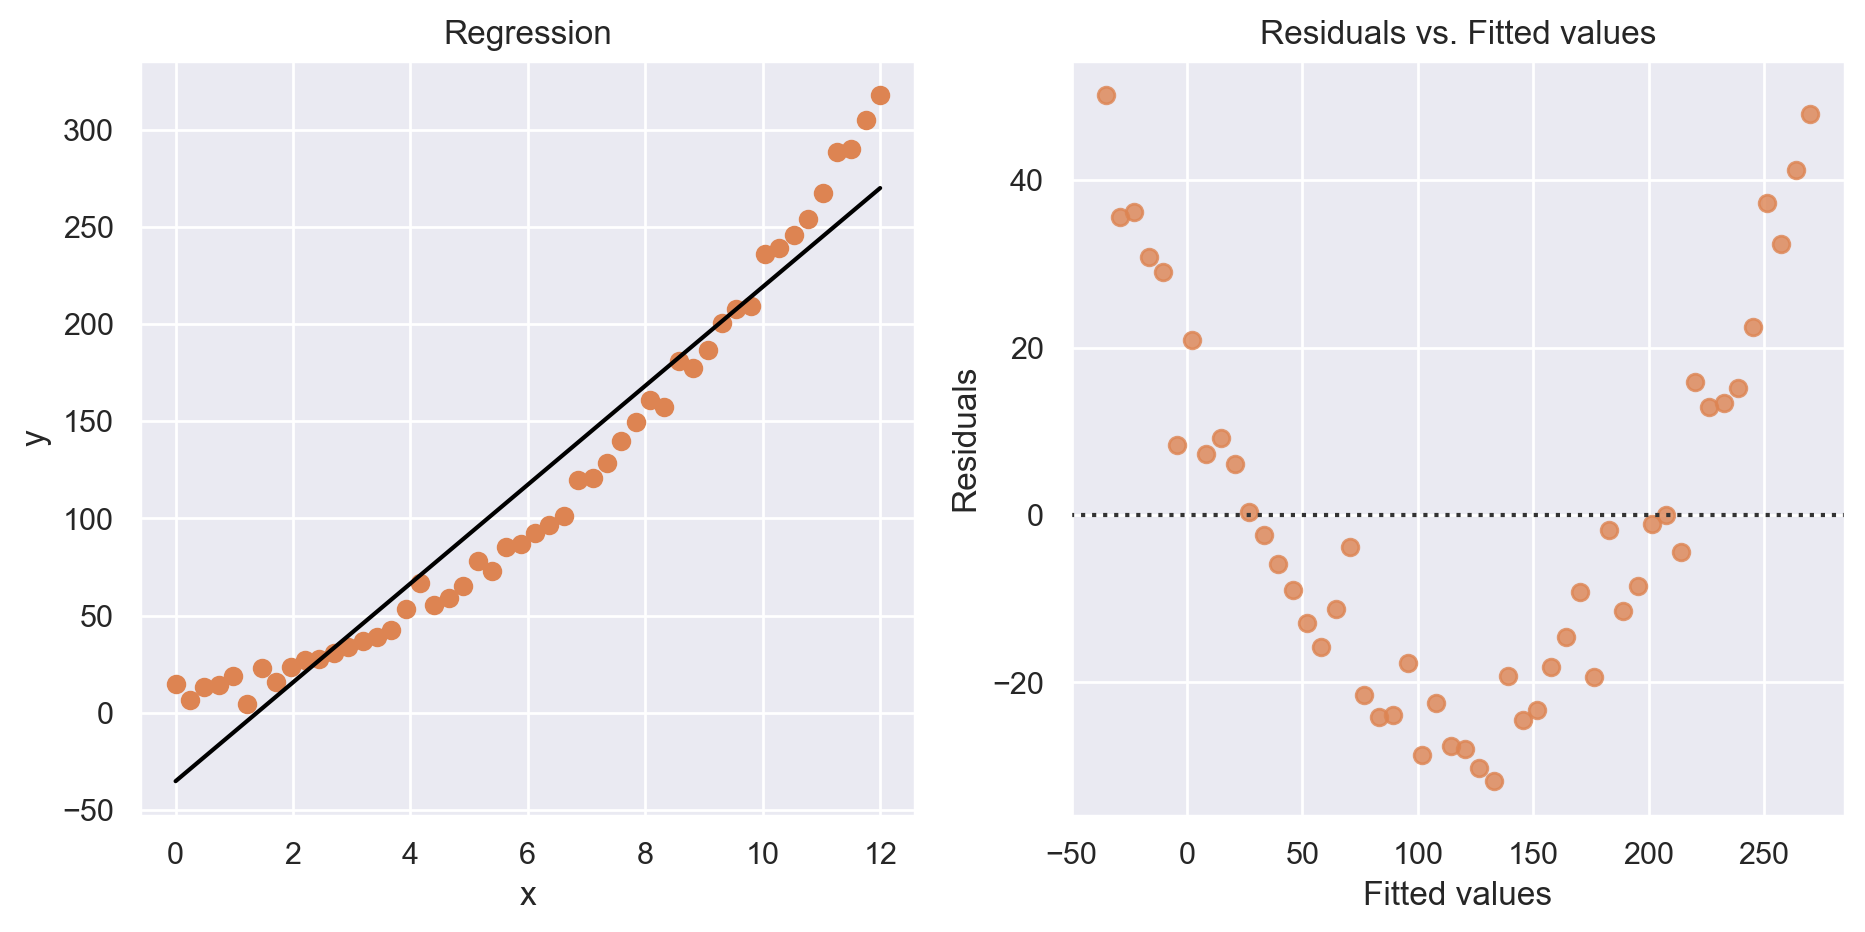

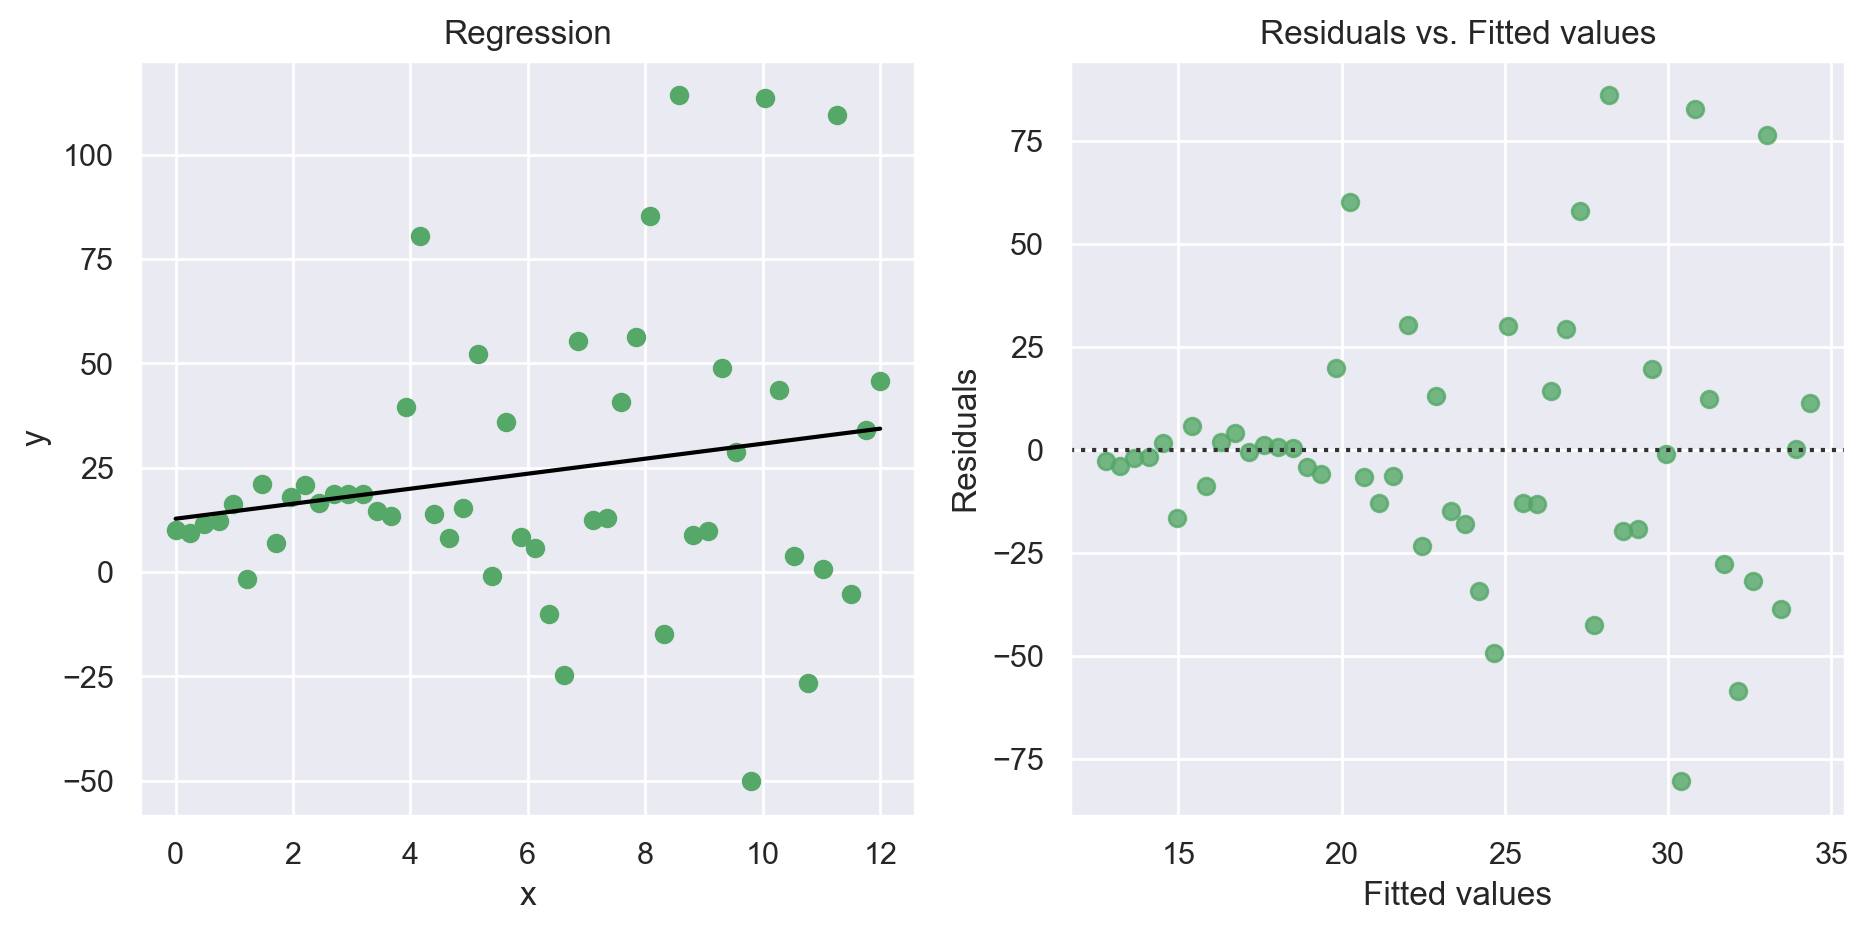

In [196]:
def plot_residuals(fitted, resid, ax, **args):
    sns.residplot(ax=ax, x=fitted, y=resid, **args)
    ax.set_title("Residuals vs. Fitted values")
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Residuals")
    return ax

def plot_regression_scatter(mod, x, y, ax, **args):
    ax.plot(x, mod.predict(sm.add_constant(x)), color='black')
    ax.scatter(x, y, **args)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Regression")
    return ax

# Residuals vs. Fitted
x = np.linspace(0, 12, 50)
error = norm.rvs(size=len(x), scale=5)
y = [None]*3
y[0] = 10 + 5 * x + 2 + error  # good example
y[1] = 10 + 1.5 * x + 2*x**2 + error  # quadratic relationship
y[2] = 10 + x + error * x  # heteroscedasticity

mods = [sm.OLS(y[i], sm.add_constant(x)).fit() for i in range(3)]

for i in range(3):
    fig, ax = plt.subplots(1, 2, figsize = (11, 5))
    plot_regression_scatter(mods[i], x, y[i], ax=ax[0], color="C" + str(i))
    plot_residuals(mods[i].fittedvalues, mods[i].resid, ax=ax[1], color="C" + str(i))
    plt.show()

## Model Fit statistics

### Coefficient of determination R^2 

$R^2$ is a statistic that will give some information about the goodness of fit of a model. It is the proportion of the variation in the dependent variable that is predictable from the independent variable(s). An $R^2$ of 1 indicates that the regression predictions perfectly fit the data.

$$R^2 = \frac{\text{RegrSS}}{\text{TotalSS}}=  1 - \frac{\text{ResidSS}}{\text{TotalSS}}$$

$$\text{TotalSS} = \sum_i(y_i - \bar{y})^2$$
$$\text{ResidSS} = \sum_i(y_i - f_i)^2$$
$$\text{RegrSS} = \sum_i(f_i - \bar{y})^2$$

In [197]:
for i in range(3):
    print("R-squared of model %s : %f" % (i + 1, mods[i].rsquared))

R-squared of model 1 : 0.930227
R-squared of model 2 : 0.940599
R-squared of model 3 : 0.036857


# Regression meets Time Series

Suppose we observe the values $y_1, \ldots, y_t$ sequentially in time. In this scenerio this is the only data that we have, there are no other "predictor" variables. Can we say something about the value of $y_{t+1}$ given all the past observations $y_1, \ldots, y_n$?

## Autoregression 
The autoregressive model specifies that the output variable depends linearly on its own previous values: 

$$ Y_t =  \beta_0 + \beta_1Y_{t-1} + \beta_2Y_{t-2} + \ldots + \beta_pY_{t-p} + \epsilon$$

Where $\epsilon \sim N(0,1)$

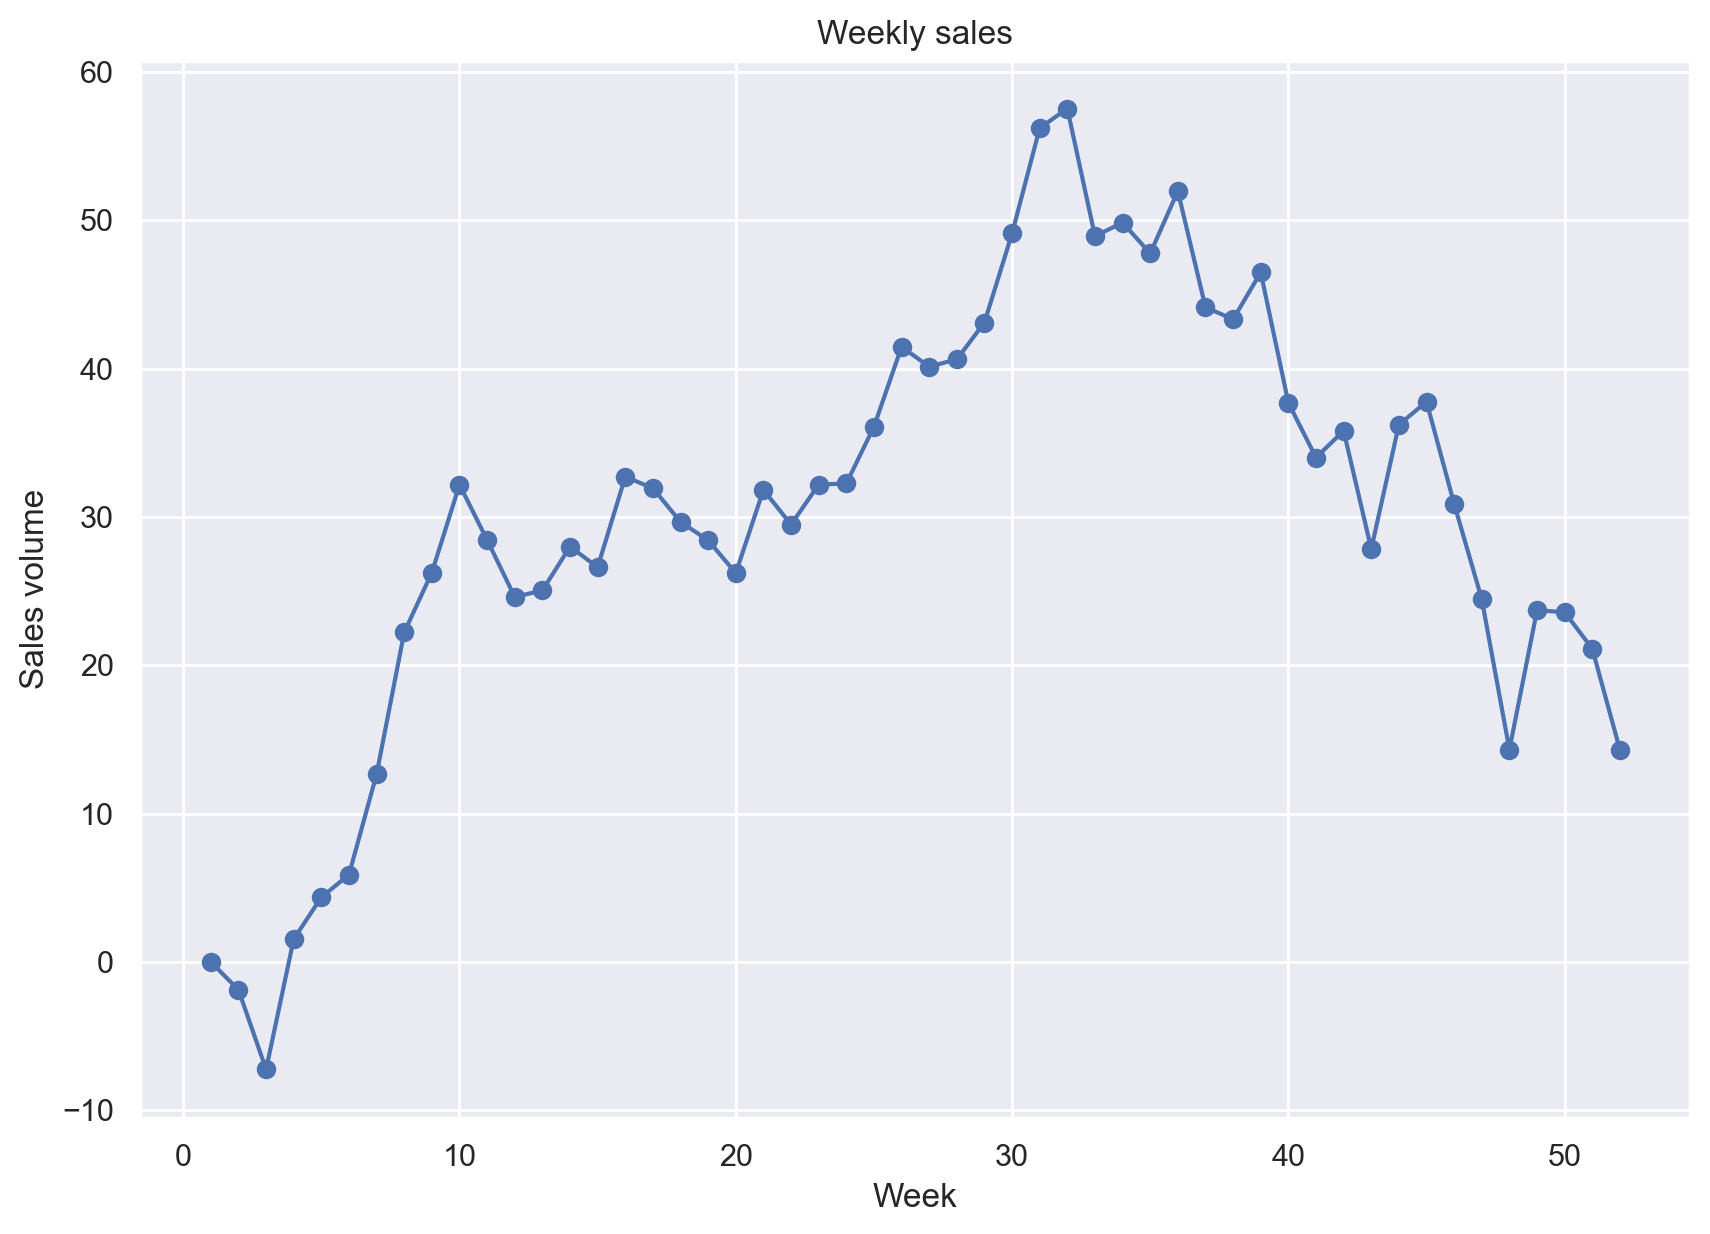

In [182]:
# AR(1) example
sales_df = pd.read_csv("data/weekly-sales.csv")

fig, ax = plt.subplots()
ax.plot(sales_df["week"], sales_df["volume"])
ax.scatter(sales_df["week"], sales_df["volume"])
ax.set_title("Weekly sales")
ax.set_xlabel("Week")
ax.set_ylabel("Sales volume")
plt.show()

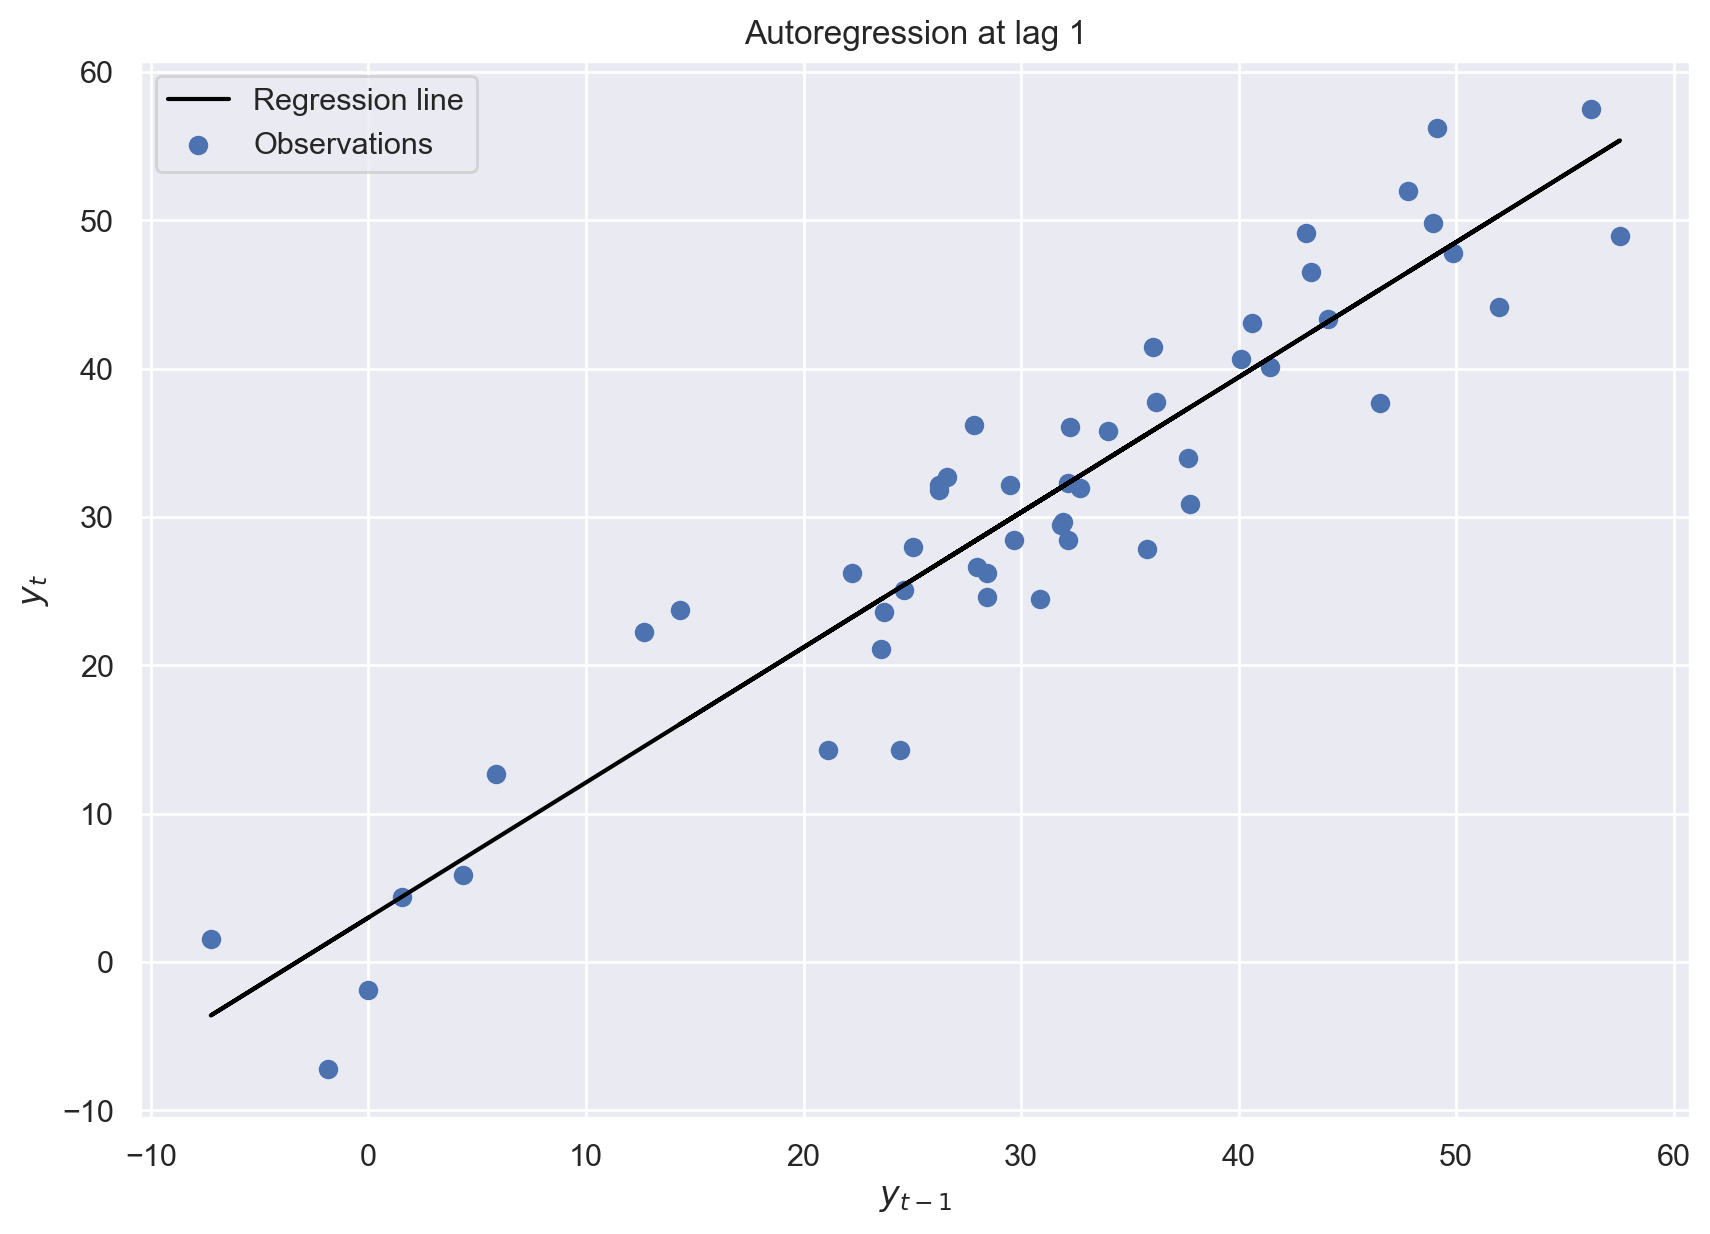

R-squared: 0.882


In [183]:
y_prev = sales_df["volume"].shift(1)[1:]
y_next = sales_df["volume"][1:]

model = sm.OLS(y_next, sm.add_constant(y_prev)).fit()

fig, ax = plt.subplots()
ax.plot(y_prev, model.predict(sm.add_constant(y_prev)), 
    color="black", label="Regression line")
ax.scatter(y_prev, y_next, label = "Observations")
ax.set_title("Autoregression at lag 1")
ax.set_xlabel("$y_{t-1}$")
ax.set_ylabel("$y_{t}$")
ax.legend()
plt.show()

print("R-squared:", round(model.rsquared, 3))